# Bag of Visual Words

From https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ with polished code

In [1]:
from src.phishIRISData import PhishIRISDataset
from src.config import config
from sklearn.model_selection import train_test_split
from src.helpers import compute_accuracy, visualize

from src.SIFT_bovw import (
    read_bw_images,
    sift_features,
    get_visual_words,
    get_frequency_vectors,
    get_tfidf,
    search_test,
)


import joblib

In [2]:
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

In [3]:
k, codebook = joblib.load(config.PROCESSED_DATA_DIR / "bovw-codebook.pkl")

## Train

In [10]:
images_training, images_testing, labels_training, labels_testing = train_test_split(
    train_dataset.img_paths, train_dataset.labels, test_size=0.2, random_state=42
)

bw_images_train, bw_images_test = (
    read_bw_images(images_training),
    read_bw_images(images_testing),
)

In [11]:
# keypoints_train, descriptors_train = sift_features(bw_images_train)
# keypoints_test, descriptors_test = sift_features(bw_images_test)
# 
# joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
# joblib.dump(descriptors_test, config.PROCESSED_DATA_DIR / "bovw-test.pkl")

descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_test = joblib.load(config.PROCESSED_DATA_DIR / "bovw-test.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_test = get_visual_words(descriptors_test, codebook)

In [20]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_test = get_frequency_vectors(visual_words_test, k)

In [21]:
tfidf_train = get_tfidf(frequency_vectors_train)
tfidf_test = get_tfidf(frequency_vectors_test)

df.shape, df[:5]: (200,), [706 958 884 633 882]
idf.shape, idf[:5]: (200,), [0.39693021 0.09169767 0.17208838 0.50607502 0.17435339]
df.shape, df[:5]: (200,), [178 244 231 147 227]
idf.shape, idf[:5]: (200,), [0.39037048 0.07498581 0.12973632 0.58172145 0.14720401]


In [22]:
search_test(tfidf_test[0], tfidf_train)

(array([538, 489,  33,  81, 290]),
 array([0.98449263, 0.94872002, 0.89343473, 0.80111785, 0.75056325]))

In [25]:
print(labels_testing[0])
for idx, el in enumerate([538, 489, 33, 81, 290]):
    print(f"{idx}: {labels_training[el]}")

chase
0: chase
1: chase
2: chase
3: chase
4: dropbox


In [26]:
k1, d1 = sift_features([bw_images_test[15]])
vw1 = get_visual_words(d1, codebook)
fv1 = get_frequency_vectors(vw1, k)

len before: 1
indexes: []
len after: 1


In [28]:
import matplotlib.pyplot as plt

plt.bar(list(range(k)), fv1[0])
plt.show()

NameError: name 'fv1' is not defined

In [ ]:
search_test(
    fv1[0], tfidf_train, search_image=bw_images_test[15], db_images=bw_images_train
)

In [30]:
labels_training[55], labels_testing[15]

('facebook', 'facebook')

## Evaluation

In [4]:
bw_train_images = read_bw_images(train_dataset.img_paths)
bw_val_images = read_bw_images(val_dataset.img_paths)

KeyboardInterrupt: 

In [7]:
keypoints_train, descriptors_train = sift_features(bw_train_images)
keypoints_val, descriptors_val = sift_features(bw_val_images)

len before: 1313
indexes: []
len after: 1313
len before: 1539
indexes: []
len after: 1539


In [4]:
# joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
# joblib.dump(descriptors_val, config.PROCESSED_DATA_DIR / "bovw-val.pkl")

descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_val = joblib.load(config.PROCESSED_DATA_DIR / "bovw-val.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_val = get_visual_words(descriptors_val, codebook)

In [5]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_val = get_frequency_vectors(visual_words_val, k)

In [6]:
tfidf_train = get_tfidf(frequency_vectors_train)
tfidf_val = get_tfidf(frequency_vectors_val)

df.shape, df[:5]: (200,), [706 958 884 633 882]
idf.shape, idf[:5]: (200,), [0.39693021 0.09169767 0.17208838 0.50607502 0.17435339]
df.shape, df[:5]: (200,), [1238 1427 1285 1165 1375]
idf.shape, idf[:5]: (200,), [0.21763568 0.07555852 0.18037414 0.27841177 0.11267912]


In [7]:
y_pred = []
y_conf = []
y_true = []

for idx, (X, label) in enumerate(val_dataset):
    indexes, confidence_scores = search_test(frequency_vectors_val[idx], tfidf_train, top_k=1)
    _, pred_label = train_dataset[indexes[0]]
    y_pred.append(pred_label)
    y_conf.append(confidence_scores[0])
    y_true.append(label)

In [8]:
compute_accuracy(y_true, y_pred)

acc:			26.51072
balanced_acc:	6.06909


(0.2651072124756335, 0.0606908646463782)

In [9]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average="weighted")

0.32298145804281186

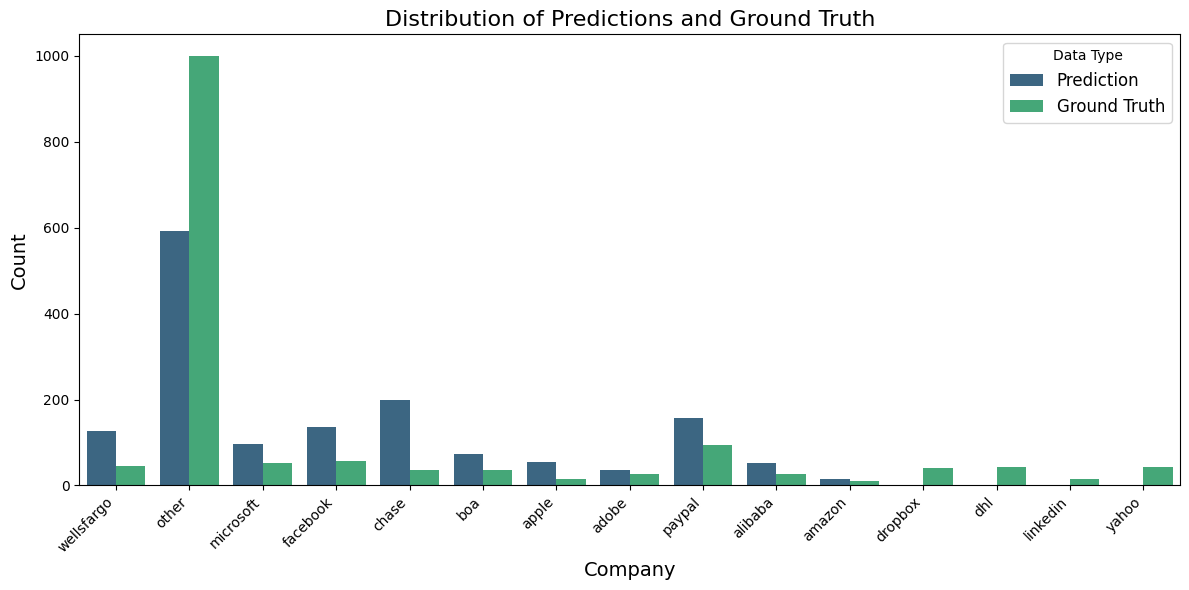

In [10]:
data = visualize(y_true, y_pred)

In [11]:
data[data["Type"] == "Prediction"]["Company"].value_counts()

Company
other         592
chase         199
paypal        158
facebook      135
wellsfargo    127
microsoft      96
boa            73
apple          54
alibaba        52
adobe          37
amazon         16
Name: count, dtype: int64

In [12]:
data[data["Type"] == "Ground Truth"]["Company"].value_counts()

Company
other         1000
paypal          93
facebook        57
microsoft       53
wellsfargo      45
yahoo           44
dhl             42
dropbox         40
chase           37
boa             35
adobe           27
alibaba         26
apple           15
linkedin        14
amazon          11
Name: count, dtype: int64